<a href="https://colab.research.google.com/github/chinmoyd1/technical_analysis_NN/blob/main/TA_Patern_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab?newreg=5d6b616eb23c4a2f9f6e78a8c948d56d
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda
!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4079    0  4079    0     0  13892      0 --:--:-- --:--:-- --:--:-- 13921
100  517k  100  517k    0     0   604k      0 --:--:-- --:--:-- --:--:-- 3576k
--2025-03-10 15:22:03--  https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
Resolving anaconda.org (anaconda.org)... 104.19.145.37, 104.19.144.37, 2606:4700::6813:9125, ...
Connecting to anaconda.org (anaconda.org)|104.19.145.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5f738b4b78d4370a69f82984/673b62920c609ff6945bb24d?response-content-disposition=attachment%3B%20filename%3D%22ta-lib-0.5.1-py311h9ecbd09_0.conda%22%3B%20filename%2A%3DUTF-8%27%27ta-lib-0.5.1-py311h9ecbd09_0.conda&response-content-type=application%2Foctet-stream&X-Amz-Algorithm=

In [ ]:
import numpy as np
import pandas as pd
import talib
import yfinance
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
# Load historical OHLCV data
def load_data(ticker, time_perios, interval='1d'):
    end = date.today()
    start = end - relativedelta(years=time_perios)

    df = yfinance.download(ticker, start=start, end=end, interval=interval)
    # df = df.reset_index()
    df.columns = [col[0] for col in df.columns]
    # df.set_index('Date', inplace=True)
    return df

In [ ]:
# Identify Double Top pattern
def detect_double_top(df, lookbacks=[10, 20, 30, 50, 80, 100]):
    df['Double_Top'] = 0
    for lookback in lookbacks:
      for i in range(lookback, len(df) - lookback):
          highs = df['High'].iloc[i-lookback:i+lookback]
          peak = df['High'].iloc[i]
          if peak == max(highs) and abs(df['High'].iloc[i] - df['High'].iloc[i-lookback//2]) < 0.02 * peak:
              df.at[df.index[i], 'Double_Top'] = 1
    return df

# Identify Double Bottom pattern
def detect_double_bottom(df, lookbacks=[10, 20, 30, 50, 80, 100]):
    df['Double_Bottom'] = 0
    for lookback in lookbacks:
      for i in range(lookback, len(df) - lookback):
          lows = df['Low'].iloc[i-lookback:i+lookback]
          trough = df['Low'].iloc[i]
          if trough == min(lows) and abs(df['Low'].iloc[i] - df['Low'].iloc[i-lookback//2]) < 0.02 * trough:
              df.at[df.index[i], 'Double_Bottom'] = 1
    return df

# Identify Wedge pattern
def detect_wedge(df, lookbacks=[14, 20, 30, 50, 80, 100]):
    df['Falling_Wedge'] = 0
    df['Rising_Wedge'] = 0
    for window in lookbacks:
      for i in range(window, len(df) - window):
          high_trend = np.polyfit(range(window), df['High'].iloc[i-window:i], 1)[0]
          low_trend = np.polyfit(range(window), df['Low'].iloc[i-window:i], 1)[0]

          if high_trend < 0 and low_trend < 0 and abs(high_trend - low_trend) < 0.1:
              df.at[df.index[i], 'Falling_Wedge'] = 1
          elif high_trend > 0 and low_trend > 0 and abs(high_trend - low_trend) < 0.1:
              df.at[df.index[i], 'Rising_Wedge'] = 1
    return df

def detect_pennant(df, lookbacks=[14, 20, 30, 50, 80, 100]):
    df['Bullish_Pennant'] = 0
    df['Bearish_Pennant'] = 0
    for window in lookbacks:
      for i in range(window, len(df) - window):
          high_trend = np.polyfit(range(window), df['High'].iloc[i-window:i], 1)[0]
          low_trend = np.polyfit(range(window), df['Low'].iloc[i-window:i], 1)[0]

          if abs(high_trend - low_trend) < 0.05:
              if high_trend > 0:
                  df.at[df.index[i], 'Bullish_Pennant'] = 1
              elif high_trend < 0:
                  df.at[df.index[i], 'Bearish_Pennant'] = 1
    return df

# Identify Head and Shoulders & Inverse Head and Shoulders patterns
def detect_head_and_shoulders(df, lookbacks=[10, 20, 30, 50, 80, 100]):
    df['Head_Shoulders'] = 0
    df['Inverse_Head_Shoulders'] = 0
    for lookback in lookbacks:
      for i in range(lookback, len(df) - lookback):
          left_shoulder = df['High'].iloc[i-lookback//2]
          head = df['High'].iloc[i]
          right_shoulder = df['High'].iloc[i+lookback//2]

          if left_shoulder < head and right_shoulder < head and abs(left_shoulder - right_shoulder) < 0.02 * head:
              df.at[df.index[i], 'Head_Shoulders'] = 1

          left_shoulder_low = df['Low'].iloc[i-lookback//2]
          head_low = df['Low'].iloc[i]
          right_shoulder_low = df['Low'].iloc[i+lookback//2]

          if left_shoulder_low > head_low and right_shoulder_low > head_low and abs(left_shoulder_low - right_shoulder_low) < 0.02 * head_low:
              df.at[df.index[i], 'Inverse_Head_Shoulders'] = 1
    return df

# Identify Cup and Handle pattern
def detect_cup_and_handle(df, lookbacks=[10, 20, 30, 50, 80, 100]):
    df['Cup_Handle'] = 0
    df['Inverse_Cup_Handle'] = 0
    for lookback in lookbacks:
        for i in range(lookback, len(df) - lookback):
            lows = df['Low'].iloc[i-lookback:i]
            highs = df['High'].iloc[i-lookback:i]
            peak = df['High'].iloc[i]
            trough = df['Low'].iloc[i]

            # Normal Cup and Handle
            if min(lows) < df['Low'].iloc[i-lookback//2] and peak > df['High'].iloc[i-lookback//2] * 1.05:
                df.at[df.index[i], 'Cup_Handle'] += 1

            # Inverse Cup and Handle
            if max(highs) > df['High'].iloc[i-lookback//2] and trough < df['Low'].iloc[i-lookback//2] * 0.95:
                df.at[df.index[i], 'Inverse_Cup_Handle'] += 1
    return df

# Identify Trendline Breakout Strategy
def detect_trendline_breakout(df, lookbacks=[10, 20, 30, 50, 80, 100]):
    df['Trendline_Breakout'] = 0
    for lookback in lookbacks:
      for i in range(lookback, len(df)):
          highs = df['High'].iloc[i-lookback:i]
          lows = df['Low'].iloc[i-lookback:i]
          resistance = max(highs)
          support = min(lows)
          if df['Close'].iloc[i] > resistance:
              df.at[df.index[i], 'Trendline_Breakout'] = 1
          elif df['Close'].iloc[i] < support:
              df.at[df.index[i], 'Trendline_Breakout'] = -1
    return df

# Identify SMA, DMA, MFI, MACD
def calculate_indicators(df):
    df['SMA_50'] = talib.SMA(df['Close'], timeperiod=50)
    df['SMA_200'] = talib.SMA(df['Close'], timeperiod=200)
    df['EMA_50'] = talib.EMA(df['Close'], timeperiod=50)
    df['EMA_200'] = talib.EMA(df['Close'], timeperiod=200)
    df['MFI'] = talib.MFI(df['High'], df['Low'], df['Close'], df['Volume'], timeperiod=14)
    df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)

    df['Upper_Band'], df['Middle_Band'], df['Lower_Band'] = talib.BBANDS(df['Close'], timeperiod=20)
    df['Bollinger_Breakout_Up'] = df['Close'] > df['Upper_Band']
    df['Bollinger_Breakout_Down'] = df['Close'] < df['Lower_Band']

    # Golden Cross (SMA 50 crosses above SMA 200)
    df['Golden_Cross'] = (df['SMA_50'] > df['SMA_200']) & (df['SMA_50'].shift(1) <= df['SMA_200'].shift(1))
    # Death Cross (SMA 50 crosses below SMA 200)
    df['Death_Cross'] = (df['SMA_50'] < df['SMA_200']) & (df['SMA_50'].shift(1) >= df['SMA_200'].shift(1))

    # MACD Bullish and Bearish Crossover
    df['MACD_Bullish_Crossover'] = (df['MACD'] > df['MACD_Signal']) & (df['MACD'].shift(1) <= df['MACD_Signal'].shift(1))
    df['MACD_Bearish_Crossover'] = (df['MACD'] < df['MACD_Signal']) & (df['MACD'].shift(1) >= df['MACD_Signal'].shift(1))

    return df

# Identify candlestick patterns using TA-Lib
def detect_talib_patterns(df):
    patterns = {
        'Morning_Star': talib.CDLMORNINGSTAR,
        'Evening_Star': talib.CDLEVENINGSTAR,
        'Three_White_Soldiers': talib.CDL3WHITESOLDIERS,
        'Three_Black_Crows': talib.CDL3BLACKCROWS,
        'Rising_Three_Methods': talib.CDLRISEFALL3METHODS,
        'Tri_Star_Top': talib.CDLTRISTAR,
    }
    for name, func in patterns.items():
        df[name] = func(df['Open'], df['High'], df['Low'], df['Close'])
    return df

# Function to label buy/sell signals based on 13% gain or 15% drop within 4 months
def label_trades(df):
    df['Buy_Signal'] = False
    df['Sell_Signal'] = False
    holding_period = 80  # Approx 4 months (trading days)

    for i in range(len(df) - holding_period):
        future_max = df['Close'].iloc[i+1:i+holding_period].max()
        future_min = df['Close'].iloc[i+1:i+holding_period].min()

        # 13% of profit in 4 months
        if (future_max / df['Close'].iloc[i] - 1) >= 0.13:
            df.at[df.index[i], 'Buy_Signal'] = True
        # 15% of loss in 4 months
        if (future_min / df['Close'].iloc[i] - 1) <= -0.15:
            df.at[df.index[i], 'Sell_Signal'] = True
    return df

In [ ]:
# Plot detected patterns
def plot_patterns(df):
    plt.figure(figsize=(16,6))
    plt.plot(df.index, df['Close'], label='Close Price', color='blue', linewidth=0.5)

    # SMA
    plt.plot(df.index, df['SMA_50'], label='SMA 50', linestyle='dashed', color='green')
    plt.plot(df.index, df['SMA_200'], label='SMA 200', linestyle='dashed', color='red')
    plt.plot(df.index, df['EMA_50'], label='EMA 50', linestyle='dashed', color='brown')
    plt.plot(df.index, df['EMA_200'], label='EMA 200', linestyle='dashed', color='pink')
    # Mark Golden and Death Cross events
    plt.scatter(df.index[df['Golden_Cross']], df['Close'][df['Golden_Cross']], label='Golden Cross', color='lime', marker='^', s=100)
    plt.scatter(df.index[df['Death_Cross']], df['Close'][df['Death_Cross']], label='Death Cross', color='black', marker='v', s=100)
    # MACD
    plt.scatter(df.index[df['MACD_Bullish_Crossover']], df['Close'][df['MACD_Bullish_Crossover']], label='MACD Bullish', color='green', marker='^', s=100)
    plt.scatter(df.index[df['MACD_Bearish_Crossover']], df['Close'][df['MACD_Bearish_Crossover']], label='MACD Bearish', color='red', marker='v', s=100)

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Golden Indicators')
    plt.show()

    # Trendline breakout
    plt.figure(figsize=(16,6))
    plt.plot(df.index, df['Close'], label='Close Price', color='black', linewidth=0.5)
    plt.scatter(df.index[df['Trendline_Breakout'] == 1], df['Close'][df['Trendline_Breakout'] == 1], label='Trendline Breakout Up', color='green', marker='^', s=100)
    plt.scatter(df.index[df['Trendline_Breakout'] == -1], df['Close'][df['Trendline_Breakout'] == -1], label='Trendline Breakout Down', color='red', marker='v', s=100)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Trendline Breakout')
    plt.show()

    # Bollinger Band
    plt.figure(figsize=(16,6))
    plt.plot(df.index, df['Close'], label='Close Price', color='black', linewidth=0.5)
    plt.fill_between(df.index, df['Upper_Band'], df['Lower_Band'], color='gray', alpha=0.3, label='Bollinger Bands')
    plt.scatter(df.index[df['Bollinger_Breakout_Up']], df['Close'][df['Bollinger_Breakout_Up']], label='Bollinger Breakout Up', color='green', marker='^', s=100)
    plt.scatter(df.index[df['Bollinger_Breakout_Down']], df['Close'][df['Bollinger_Breakout_Down']], label='Bollinger Breakout Down', color='red', marker='v', s=100)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Bollinger Band')
    plt.show()


    plt.figure(figsize=(16, 2))
    plt.plot(df.index, df['MACD'], label='MACD', color='blue')
    plt.plot(df.index, df['MACD_Signal'], label='Signal Line', color='red')
    plt.bar(df.index, df['MACD_Hist'], label='MACD Histogram', color='gray', alpha=0.5)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('MACD')
    plt.title('MACD Indicator')
    plt.show()

    plt.figure(figsize=(16, 2))
    plt.plot(df.index, df['MFI'], label='MFI', color='purple')
    plt.axhline(80, linestyle='dashed', color='red')
    plt.axhline(20, linestyle='dashed', color='green')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('MFI')
    plt.title('Money Flow Index')
    plt.show()

    plt.figure(figsize=(16, 2))
    plt.plot(df.index, df['RSI'], label='RSI', color='orange')
    plt.axhline(70, linestyle='dashed', color='red')
    plt.axhline(30, linestyle='dashed', color='green')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.title('Relative Strength Index')
    plt.show()

    # plt.scatter(df.index[df['Double_Top'] == 1], df['Close'][df['Double_Top'] == 1], label='Double Top', color='red', marker='^')
    # plt.scatter(df.index[df['Double_Bottom'] == 1], df['Close'][df['Double_Bottom'] == 1], label='Double Bottom', color='lime', marker='v')
    # plt.scatter(df.index[df['Falling_Wedge'] == 1], df['Close'][df['Falling_Wedge'] == 1], label='Falling Wedge', color='purple', marker='s')
    # plt.scatter(df.index[df['Rising_Wedge'] == 1], df['Close'][df['Rising_Wedge'] == 1], label='Rising Wedge', color='pink', marker='s')
    # plt.scatter(df.index[df['Bullish_Pennant'] == 1], df['Close'][df['Bullish_Pennant'] == 1], label='Bullish Pennant', color='orange', marker='d')
    # plt.scatter(df.index[df['Bearish_Pennant'] == 1], df['Close'][df['Bearish_Pennant'] == 1], label='Bearish Pennant', color='black', marker='d')
    # plt.scatter(df.index[df['Head_Shoulders'] == 1], df['Close'][df['Head_Shoulders'] == 1], label='Head & Shoulders', color='black', marker='x')
    # plt.scatter(df.index[df['Inverse_Head_Shoulders'] == 1], df['Close'][df['Inverse_Head_Shoulders'] == 1], label='Inverse Head & Shoulders', color='cyan', marker='x')
    plt.figure(figsize=(16,6))
    plt.plot(df.index, df['Close'], label='Close Price', color='blue', linewidth=0.5)
    for pattern in ['Morning_Star', 'Evening_Star', 'Three_White_Soldiers', 'Three_Black_Crows', 'Rising_Three_Methods', 'Tri_Star_Top']:
      plt.scatter(df.index[df[pattern] != 0], df['Close'][df[pattern] != 0], label=pattern, marker='o')

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Detected Candlestick Patterns')
    plt.show()

    plt.figure(figsize=(16,6))
    plt.plot(df.index, df['Close'], label='Close Price', color='blue', linewidth=0.5)
    for pattern in ['Double_Top', 'Double_Bottom', 'Falling_Wedge', 'Rising_Wedge', 'Bullish_Pennant', 'Bearish_Pennant', 'Head_Shoulders', 'Inverse_Head_Shoulders', 'Cup_Handle', 'Inverse_Cup_Handle']:
      plt.scatter(df.index[df[pattern] != 0], df['Close'][df[pattern] != 0], label=pattern, marker='o')

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Detected Technical Patterns')
    plt.show()

    plt.figure(figsize=(16,6))
    plt.plot(df.index, df['Close'], label='Close Price', color='blue', linewidth=0.5)
    plt.scatter(df.index[df['Buy_Signal']], df['Close'][df['Buy_Signal']], label='Buy Signal', color='green', marker='^', s=100)
    plt.scatter(df.index[df['Sell_Signal']], df['Close'][df['Sell_Signal']], label='Sell Signal', color='red', marker='v', s=100)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Breakout Technical Patterns')
    plt.show()

# Plot breakout pattern
def plot_breakout(pred_df):
    plt.figure(figsize=(16,6))
    plt.plot(pred_df.index, pred_df['Close'], label='Close Price', color='blue', linewidth=0.5)
    plt.scatter(pred_df.index[pred_df['Buy_Signal']], pred_df['Close'][pred_df['Buy_Signal']], label='Buy Signal', color='green', marker='^', s=100)
    plt.scatter(pred_df.index[pred_df['Sell_Signal']], pred_df['Close'][pred_df['Sell_Signal']], label='Sell Signal', color='red', marker='v', s=100)

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Breakout Technical Patterns')
    plt.show()

def plot_prediction(pred_df):
    plt.figure(figsize=(16,6))
    plt.plot(pred_df.index, pred_df['Close'], label='Close Price', color='blue', linewidth=0.5)
    plt.scatter(pred_df.index[pred_df['Buy_Signal']], pred_df['Close'][pred_df['Buy_Signal']], label='Buy Signal', color='green', marker='^', s=100)
    plt.scatter(pred_df.index[pred_df['Sell_Signal']], pred_df['Close'][pred_df['Sell_Signal']], label='Sell Signal', color='red', marker='v', s=100)

    plt.scatter(pred_df.index[pred_df['pred_buy_signal']], pred_df['Close'][pred_df['pred_buy_signal']], label='Buy Signal', color='lime', marker='^', s=100)
    plt.scatter(pred_df.index[pred_df['pred_sell_signal']], pred_df['Close'][pred_df['pred_sell_signal']], label='Sell Signal', color='orange', marker='v', s=100)

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Breakout Technical Patterns Prediction')
    plt.show()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


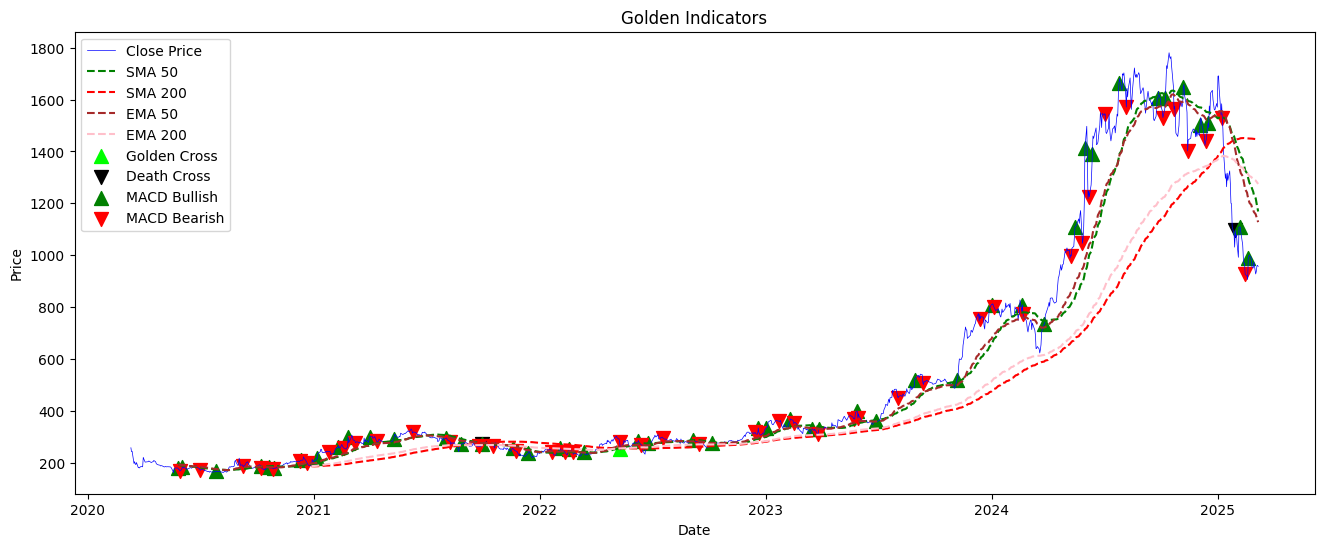

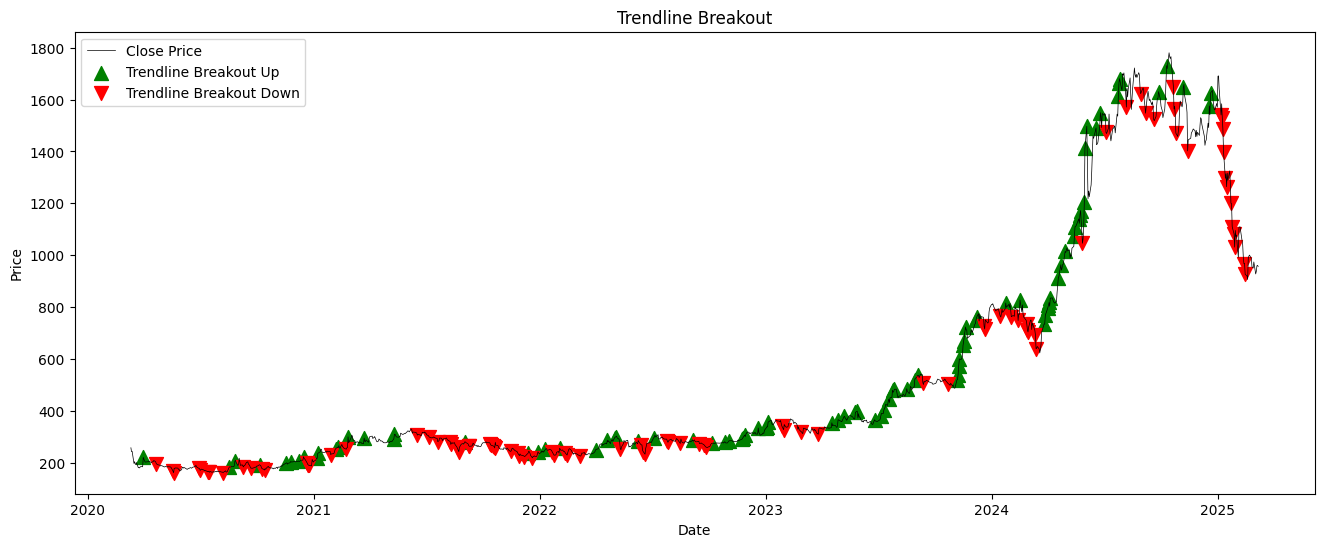

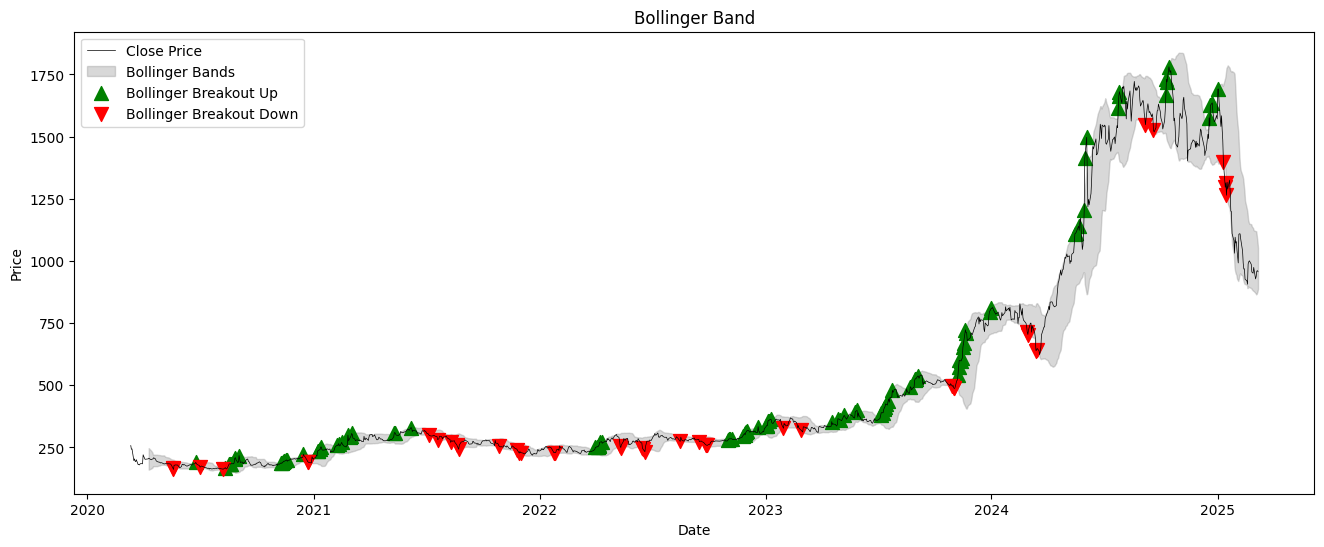

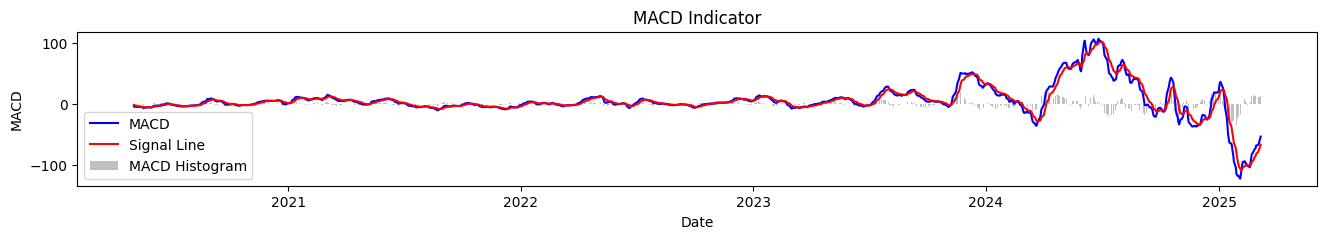

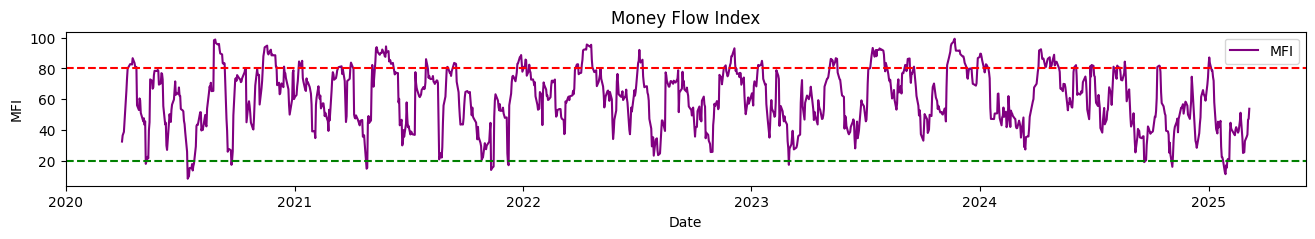

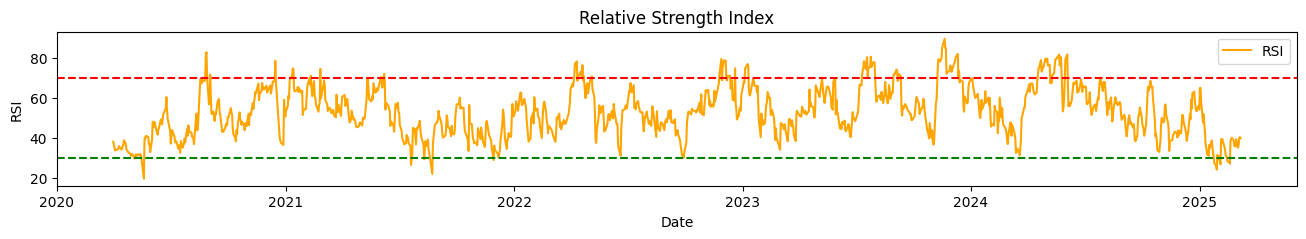

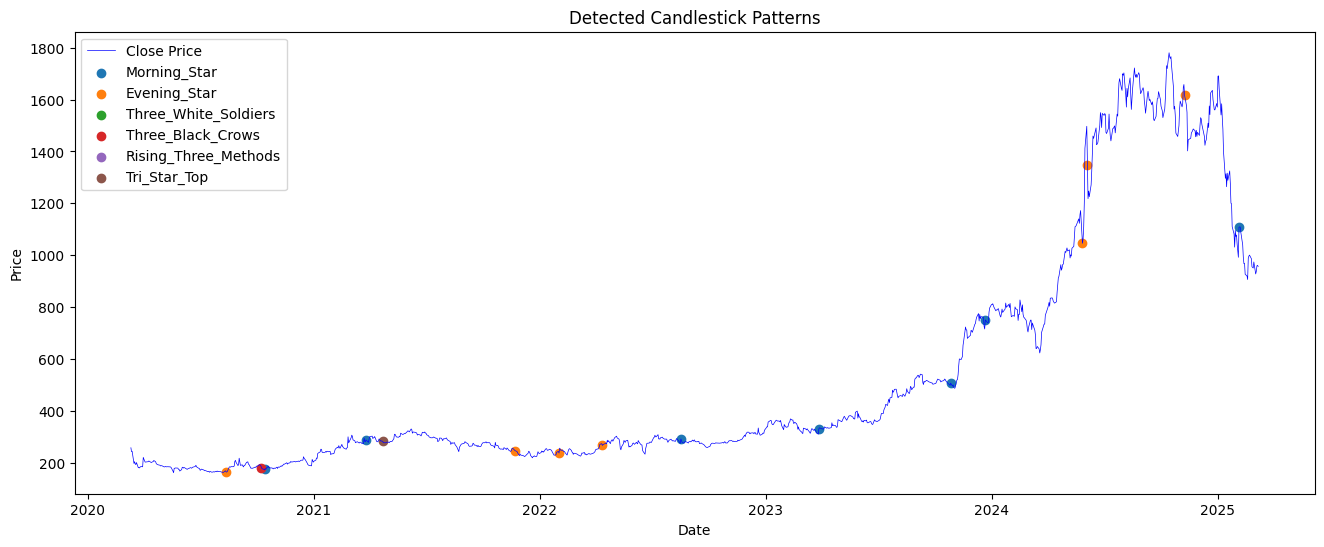

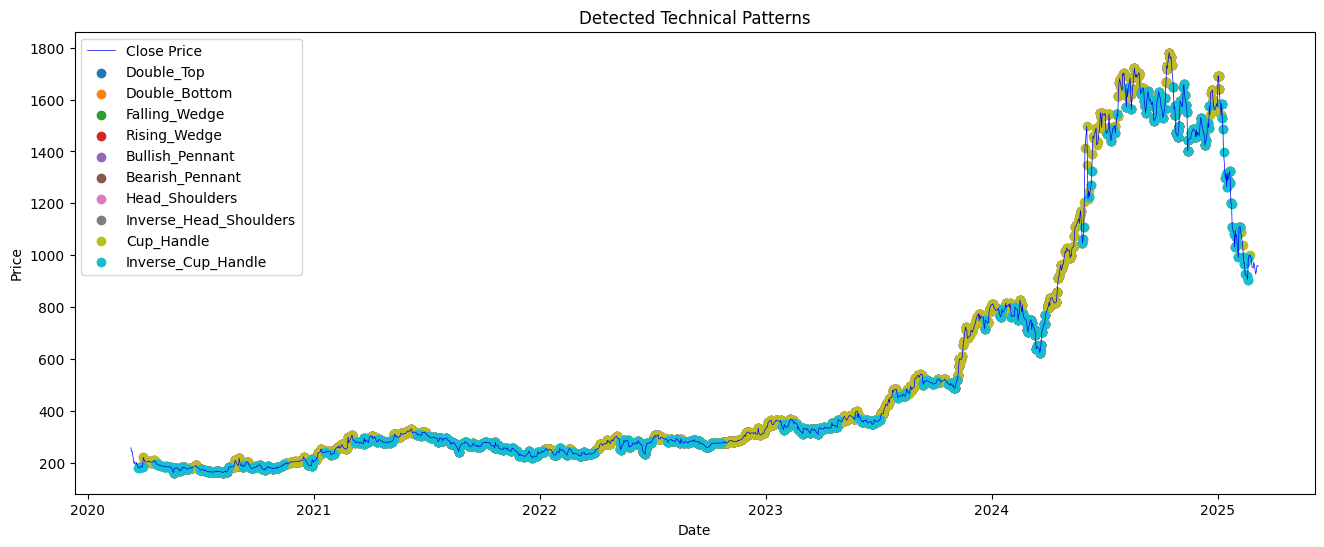

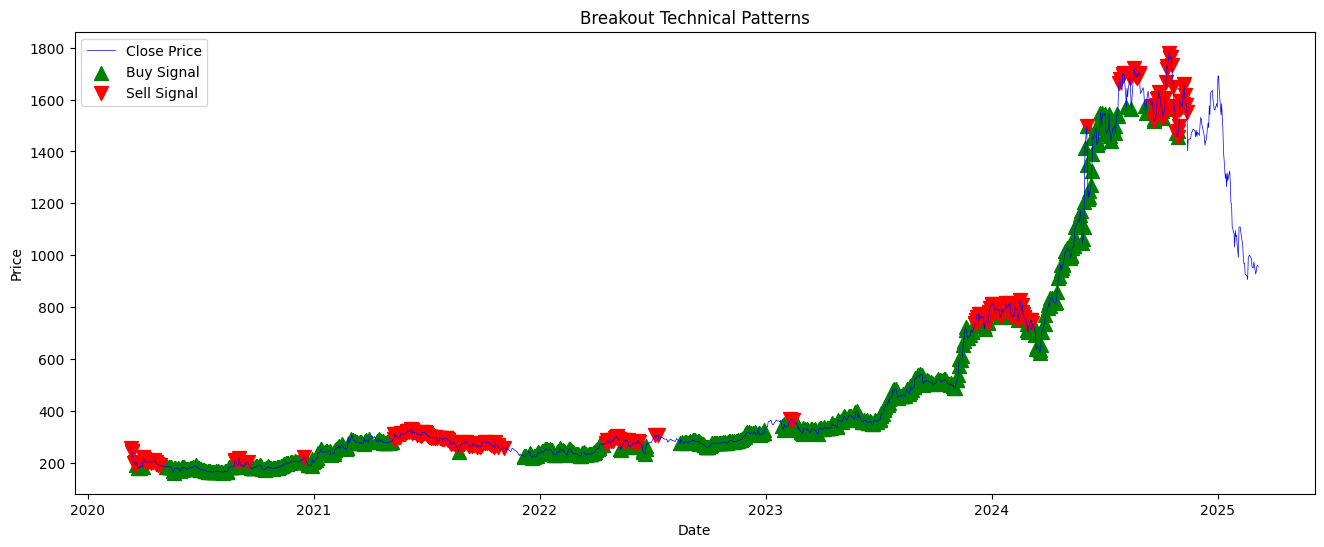

In [ ]:
df = load_data("TECHNOE.NS", 5)
numbers = list(range(7, 102)) # [10, 20, 30, 50, 80]  # list(range(7, 102))
df = detect_double_top(df, numbers)
df = detect_double_bottom(df, numbers)
df = detect_wedge(df, numbers)
df = detect_pennant(df, numbers)
df = detect_head_and_shoulders(df, numbers)
df = detect_cup_and_handle(df, numbers)

df = detect_talib_patterns(df)
df = calculate_indicators(df)
df = detect_trendline_breakout(df, numbers)
df = label_trades(df)

plot_patterns(df)

In [ ]:
# Forward & backward fill
def handle_missing_values(df):
    return df.ffill().bfill()  # Forward & backward fill

def preprocess_data(tmp_df):
  min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
  tmp_df = handle_missing_values(tmp_df)
  # tmp_df.astype(np.float32)  # Convert everything to float32

  bool_indicators = ['Bollinger_Breakout_Up', 'Bollinger_Breakout_Down', 'Golden_Cross', 'Death_Cross', 'MACD_Bullish_Crossover', 'MACD_Bearish_Crossover']
  tmp_df[bool_indicators] = tmp_df[bool_indicators].astype(np.float32)

  price_features = ['Close', 'High', 'Low', 'Open', 'Volume']
  # print((tmp_df[price_features]<0).sum())
  tmp_df[price_features] = np.log(tmp_df[price_features] + 1)
  tmp_df[price_features] = min_max_scaler.fit_transform(tmp_df[price_features]) # price will be negative after putting in scaler

  negative_values = ['SMA_50', 'SMA_200', 'EMA_50', 'EMA_200', 'MFI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI', 'Upper_Band', 'Middle_Band', 'Lower_Band']
  tmp_df[negative_values] = min_max_scaler.fit_transform(tmp_df[negative_values])

  features = tmp_df[bool_indicators + price_features + negative_values].values
  features = features.reshape(-1, len(bool_indicators + price_features + negative_values))  # Ensure 2D shape

  labels = np.where(tmp_df['Buy_Signal'], 1, np.where(tmp_df['Sell_Signal'], -1, 0))
  labels = labels.reshape(-1, 1)  # Ensure labels are 2D

  return features, labels

In [ ]:
features, labels = preprocess_data(df)

In [ ]:
# Build a Feedforward Neural Network using TensorFlow
def build_model(input_dim):
    # connecting input_layer(input_dim) -> hidden_layer(84), values are randomly intialized
    model = tf.Variable(tf.random.normal([input_dim, 84]), dtype=tf.float32)
    # connection beween (84 neurons in first layer → 42 neurons in second layer)
    weights1 = tf.Variable(tf.random.normal([84, 42]), dtype=tf.float32)
    # second hidden layer → the output layer
    weights2 = tf.Variable(tf.random.normal([42, 1]), dtype=tf.float32)

    # first hidden layer bias
    bias1 = tf.Variable(tf.zeros([84]), dtype=tf.float32)
    # second hidden layer bies
    bias2 = tf.Variable(tf.zeros([42]), dtype=tf.float32)
    # output bias
    bias3 = tf.Variable(tf.zeros([1]), dtype=tf.float32)

    return model, weights1, weights2, bias1, bias2, bias3


def train_model(features_train, labels_train, features_test, labels_test, epochs=100):
  input_dim = features_train.shape[1]
  model, weights1, weights2, bias1, bias2, bias3 = build_model(input_dim)

  # Ensure features and labels are float32
  features_train = tf.cast(features_train, tf.float32)
  labels_train = tf.cast(labels_train, tf.float32)

  features_test = tf.cast(features_test, tf.float32)
  labels_test = tf.cast(labels_test, tf.float32)

  optimizer = tf.optimizers.Adam(learning_rate=0.001)

  for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Forward pass for training data
        hidden_layer1 = tf.nn.relu(tf.matmul(features_train, model) + bias1)
        hidden_layer2 = tf.nn.relu(tf.matmul(hidden_layer1, weights1) + bias2)
        output = tf.matmul(hidden_layer2, weights2) + bias3
        # Compute the loss for the training data
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(labels_train, tf.float32), logits=output))

    # Compute gradients and update weights
    grads = tape.gradient(loss, [model, weights1, weights2, bias1, bias2, bias3])
    optimizer.apply_gradients(zip(grads, [model, weights1, weights2, bias1, bias2, bias3]))

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

    # Evaluate model on testing data after every 10 epochs
    if epoch % 10 == 0:
        # Forward pass for testing data
        hidden_layer1_test = tf.nn.relu(tf.matmul(features_test, model) + bias1)
        hidden_layer2_test = tf.nn.relu(tf.matmul(hidden_layer1_test, weights1) + bias2)
        output_test = tf.matmul(hidden_layer2_test, weights2) + bias3
        # Compute the loss for the testing data
        loss_test = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_test, logits=output_test))
        print(f'Epoch {epoch}, Test Loss: {loss_test.numpy()}')

  return model, weights1, weights2, bias1, bias2, bias3

In [ ]:
train_size = int(0.6 * len(features))  # 60% for training
val_size = int(0.2 * len(features))  # 20% for validation
test_size = len(features) - train_size - val_size  # Remaining 20% for testing

# Split the data into train, validation, and test sets
X_train = features[:train_size]
y_train = labels[:train_size]

X_val = features[train_size: train_size+val_size]
y_val = labels[train_size: train_size+val_size]

X_test = features[train_size + val_size:]
y_test = labels[train_size + val_size:]

model, weights1, weights2, bias1, bias2, bias3 = train_model(X_train, y_train, X_val, y_val, 80)

Epoch 0, Loss: 8.089207649230957
Epoch 0, Test Loss: 1.4858524799346924
Epoch 10, Loss: 4.712428569793701
Epoch 10, Test Loss: 4.711394786834717
Epoch 20, Loss: 3.1039113998413086
Epoch 20, Test Loss: 4.177253246307373
Epoch 30, Loss: 1.9734454154968262
Epoch 30, Test Loss: 7.336477756500244
Epoch 40, Loss: 1.3221039772033691
Epoch 40, Test Loss: 8.487664222717285
Epoch 50, Loss: 0.9457220435142517
Epoch 50, Test Loss: 10.61489200592041
Epoch 60, Loss: 0.6673285961151123
Epoch 60, Test Loss: 11.089740753173828
Epoch 70, Loss: 0.43623867630958557
Epoch 70, Test Loss: 11.553729057312012


In [ ]:
# Predict buy/sell signals
def predict_signals(df, model, weights1, weights2, bias1, bias2, bias3):
    # labeled_df = label_trades(df)
    features, correct_label = preprocess_data(df[-180:-80])
    predict_df = df[-180:-80].copy()
    plot_breakout(predict_df)

    # Ensure features and labels are float32
    features = tf.cast(features, tf.float32)
    # correct_label = tf.cast(correct_label, tf.float32)

    hidden_layer1 = tf.nn.relu(tf.matmul(features, model) + bias1)
    hidden_layer2 = tf.nn.relu(tf.matmul(hidden_layer1, weights1) + bias2)
    output = tf.matmul(hidden_layer2, weights2) + bias3
    predictions = tf.nn.sigmoid(output).numpy().flatten()
    predict_df['pred_buy_signal'] = predictions > 0.6
    predict_df['pred_sell_signal'] = predictions < 0.4

    # Adjust predictions to match your -1 (sell), 1 (buy), and 0 (do nothing) label scheme
    predicted_labels = tf.where(predictions > 0.6, 1, tf.where(predictions < 0.4, -1, 0))

    # Compare the predicted labels with the true labels
    correct_predictions = predicted_labels == correct_label
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    print(f'Test Accuracy: {accuracy.numpy() * 100}%')

    return predict_df

In [ ]:
# Predict buy/sell futuer call signals
def predict_future(df, model, weights1, weights2, bias1, bias2, bias3):
    features, _ = preprocess_data(df[-80:])
    predict_df = df[-80:].copy()

    # Ensure features and labels are float32
    features = tf.cast(features, tf.float32)
    # correct_label = tf.cast(correct_label, tf.float32)

    hidden_layer1 = tf.nn.relu(tf.matmul(features, model) + bias1)
    hidden_layer2 = tf.nn.relu(tf.matmul(hidden_layer1, weights1) + bias2)
    output = tf.matmul(hidden_layer2, weights2) + bias3
    predictions = tf.nn.sigmoid(output).numpy().flatten()
    predict_df['Buy_Signal'] = predictions > 0.6
    predict_df['Sell_Signal'] = predictions < 0.4

    plot_breakout(predict_df)
    return predict_df

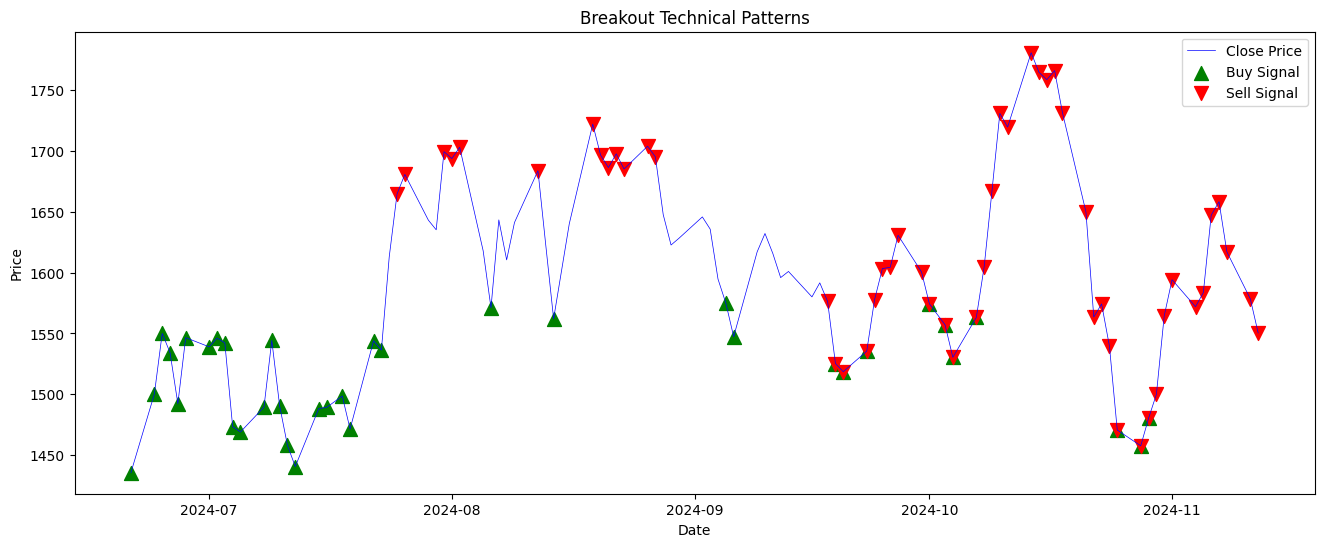

Test Accuracy: 40.07999897003174%


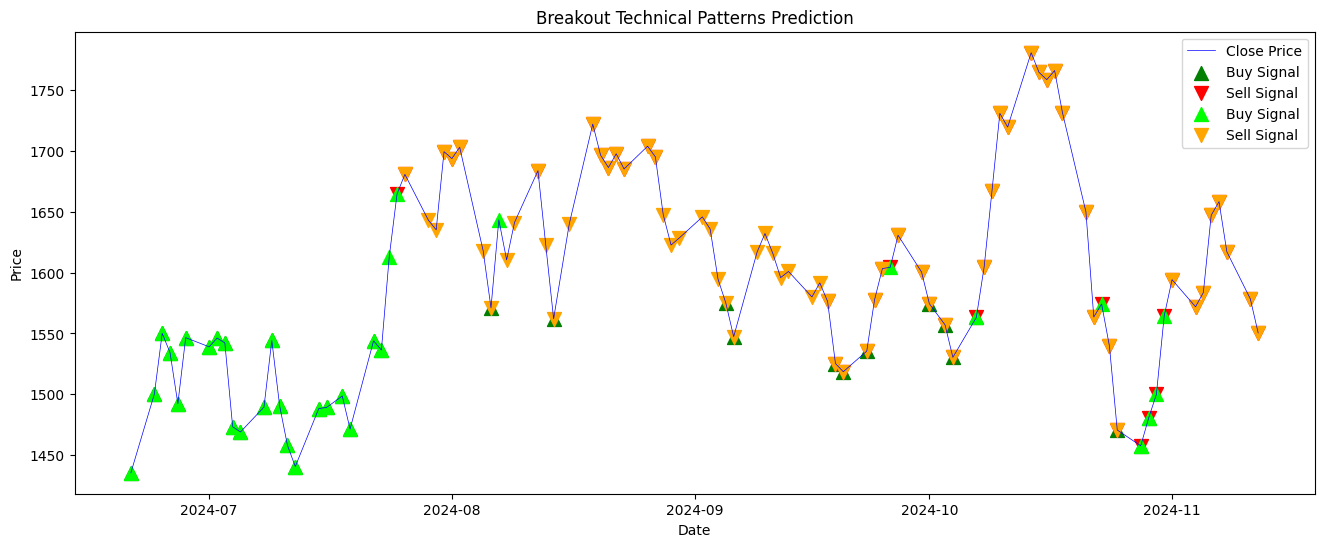

In [ ]:
predicted_df = predict_signals(df, model, weights1, weights2, bias1, bias2, bias3)
plot_prediction(predicted_df)

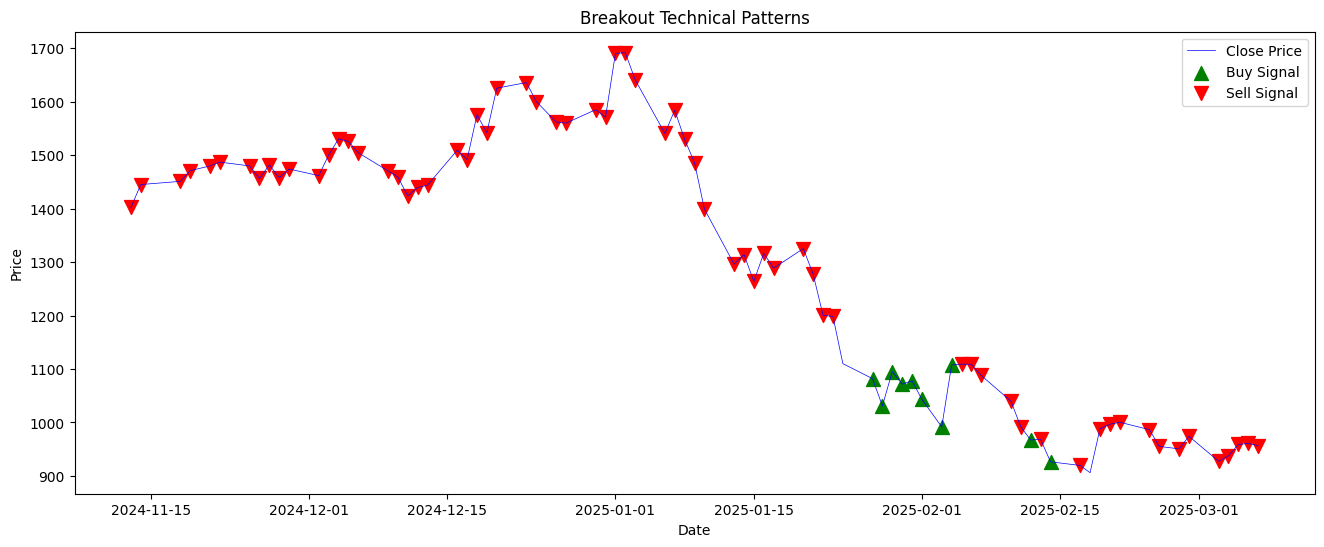

,Close,High,Low,Open,Volume,Double_Top,Double_Bottom,Falling_Wedge,Rising_Wedge,Bullish_Pennant,...,Lower_Band,Bollinger_Breakout_Up,Bollinger_Breakout_Down,Golden_Cross,Death_Cross,MACD_Bullish_Crossover,MACD_Bearish_Crossover,Trendline_Breakout,Buy_Signal,Sell_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-13,1402.000000,1470.250000,1395.400024,1450.000000,533004,0,0,1,1,1,...,1400.515779,False,False,False,False,False,True,-1,False,True
2024-11-14,1444.900024,1492.400024,1396.000000,1402.050049,178835,0,0,1,1,1,...,1399.248142,False,False,False,False,False,False,0,False,True
2024-11-18,1450.849976,1498.000000,1405.599976,1439.000000,138323,0,0,1,1,1,...,1399.641501,False,False,False,False,False,False,0,False,True
2024-11-19,1470.900024,1514.900024,1451.199951,1498.000000,80735,0,0,1,0,0,...,1395.683816,False,False,False,False,False,False,0,False,True
2024-11-21,1479.699951,1534.949951,1459.949951,1488.000000,172247,0,0,1,0,0,...,1390.034626,False,False,False,False,False,False,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-03,927.500000,979.900024,907.000000,974.400024,367593,0,0,0,0,0,...,870.445131,False,False,False,False,False,False,0,False,True
2025-03-04,937.450012,963.500000,909.000000,922.000000,216269,0,0,0,0,0,...,865.214596,False,False,False,False,False,False,0,False,True
2025-03-05,958.950012,973.299988,935.000000,937.450012,218504,0,0,0,0,0,...,868.642278,False,False,False,False,False,False,0,False,True


In [ ]:
predict_future(df, model, weights1, weights2, bias1, bias2, bias3)